# GridFM Visualization tutorial

In [1]:
from gridfm_graphkit.datasets.powergrid import GridDatasetMem
from gridfm_graphkit.datasets.data_normalization import BaseMVANormalizer
from gridfm_graphkit.utils.visualization import (
    visualize_error,
    visualize_quantity_heatmap,
)
from gridfm_graphkit.datasets.globals import PD, QD, PG, QG, VM, VA
from gridfm_graphkit.datasets.transforms import AddRandomMask

# Standard open-source libraries
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

torch.manual_seed(0)
random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and normalize the power grid dataset for grid case30 from IEEE

In [2]:
# This network was chosen for visualization purposes (networks up to 300 buses were tested)
# The number of load scenarios is 1024
network = "../data/case30_ieee"
node_normalizer, edge_normalizer = (
    BaseMVANormalizer(node_data=True),
    BaseMVANormalizer(node_data=False),
)
dataset = GridDatasetMem(
    root=network,
    norm_method="baseMVAnorm",
    node_normalizer=node_normalizer,
    edge_normalizer=edge_normalizer,
    pe_dim=20,
    transform=AddRandomMask(mask_dim=6, mask_ratio=0.5),
)

# Create a Pytorch Dataloader

In [3]:
# The scenarios are grouped in batches
loader = DataLoader(dataset, batch_size=32)

# Load gridFM-v0.2

In [4]:
model = torch.load(
    "../models/GridFM_v0_2_3.pth", weights_only=False, map_location=device
).to(device)

# State reconstruction of 1024 scenarios (6 features)

In [ ]:
model.eval()
with torch.no_grad():
    for batch in tqdm(loader):
        batch = batch.to(device)

        # Apply random masking
        mask_value_expanded = model.mask_value.expand(batch.x.shape[0], -1)
        batch.x[:, : batch.mask.shape[1]][batch.mask] = mask_value_expanded[batch.mask]

        # Perform inference
        output = model(
            batch.x, batch.pe, batch.edge_index, batch.edge_attr, batch.batch
        )

# Visualize Nodal Active Power Residuals for one load scenario

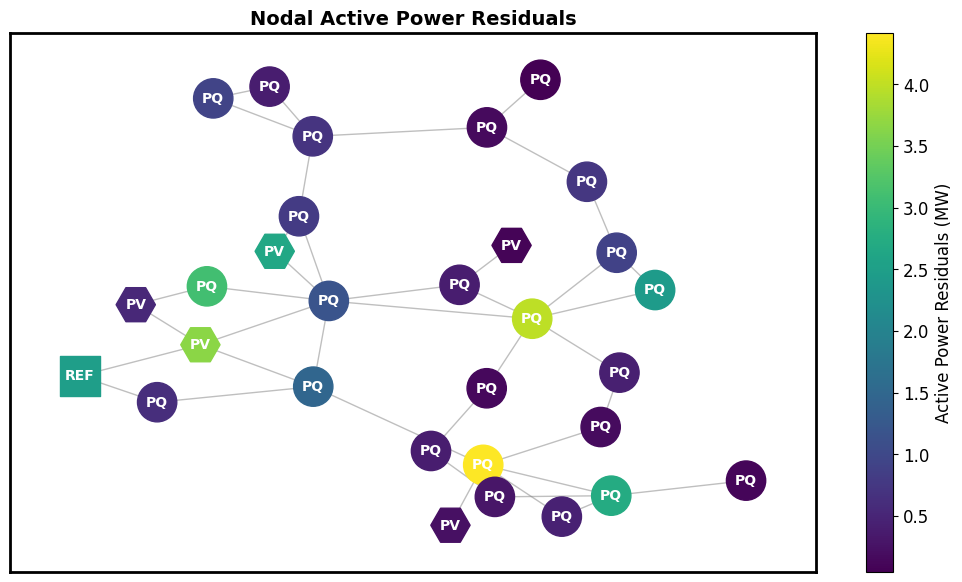

In [6]:
# select one random sample from the dataset
data_point = dataset[random.randint(0, len(dataset) - 1)]

visualize_error(data_point, model, baseMVA=node_normalizer.baseMVA, device=device)

# Visualize the state reconstruction capability of gridFM-v0.2 for each feature:
- Active Power Demand (MW)
- Reactive Power Demand (MVar)
- Active Power Generated (MW)
- Reactive Power Generated (MVar)
- Voltage Magnitude (p.u.)
- Voltage Angle (degrees)


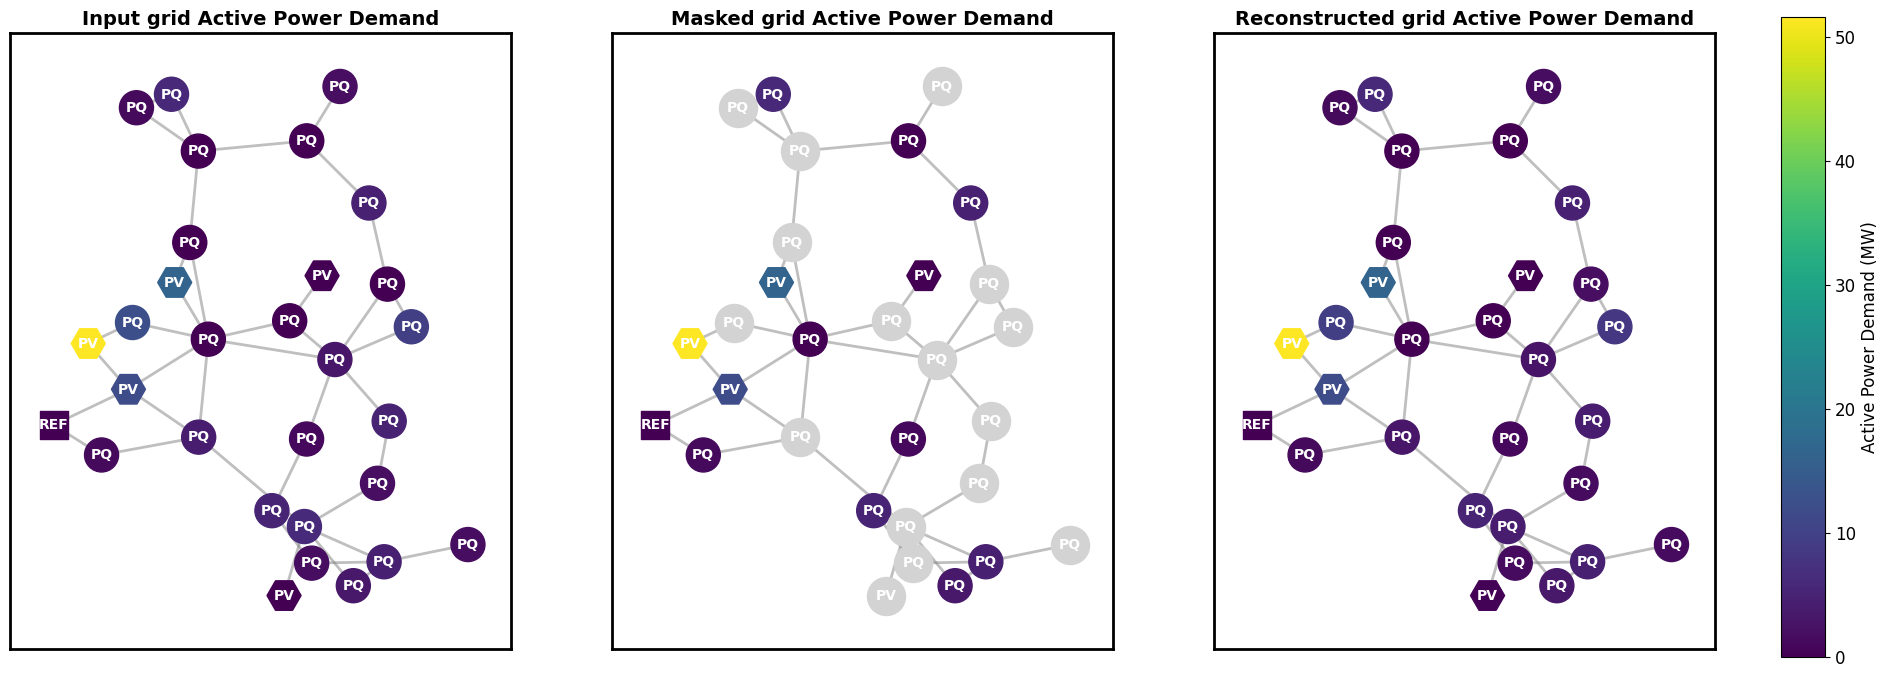

In [7]:
# Active Power Demand reconstruction
visualize_quantity_heatmap(
    data_point,
    model,
    PD,
    "Active Power Demand",
    "MW",
    node_normalizer,
    plt.cm.viridis,
    device=device,
)

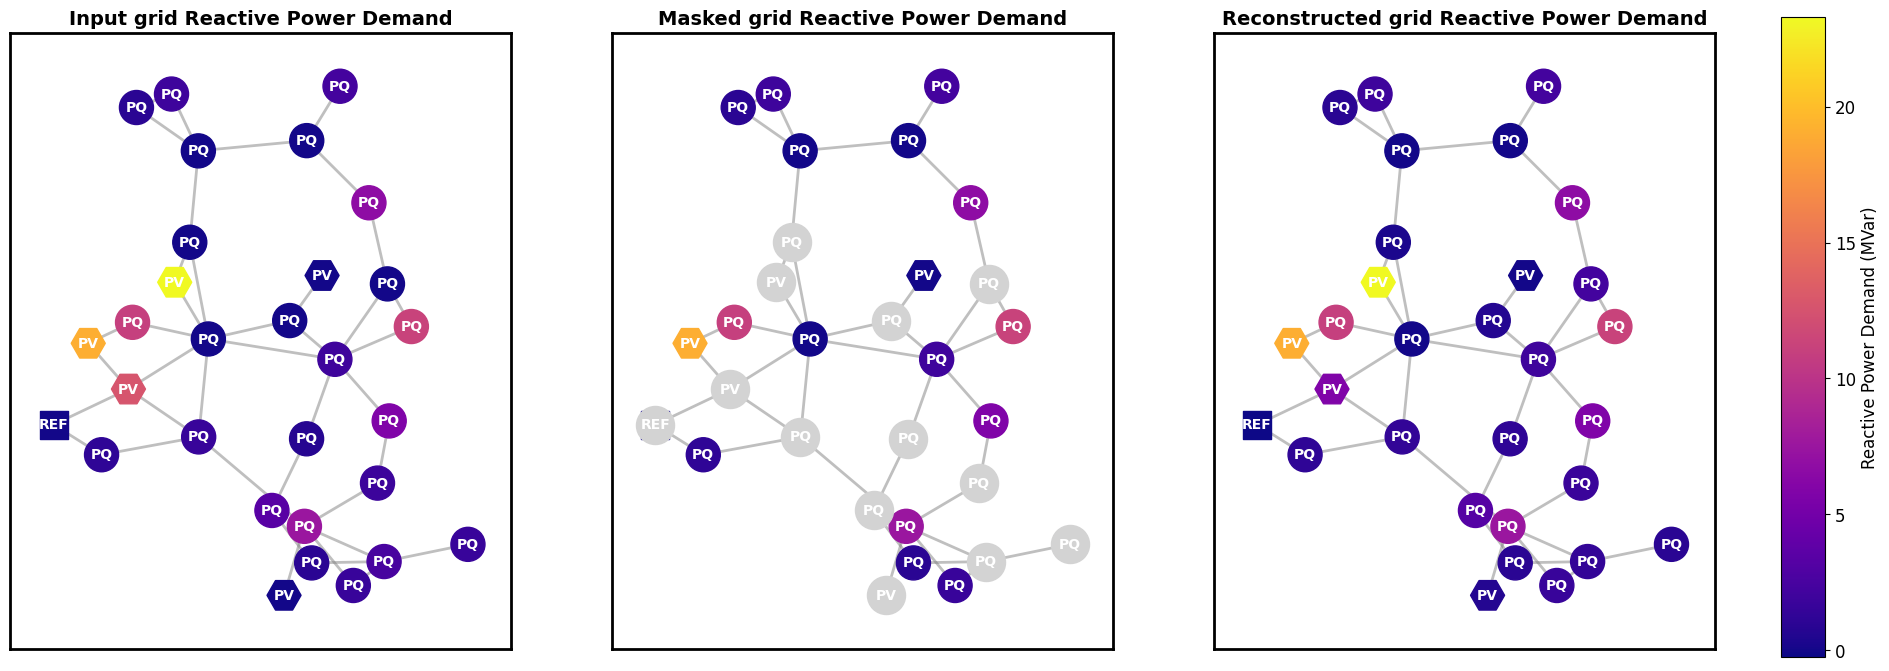

In [8]:
# Reactive Power Demand reconstruction
visualize_quantity_heatmap(
    data_point,
    model,
    QD,
    "Reactive Power Demand",
    "MVar",
    node_normalizer,
    plt.cm.plasma,
    device=device,
)

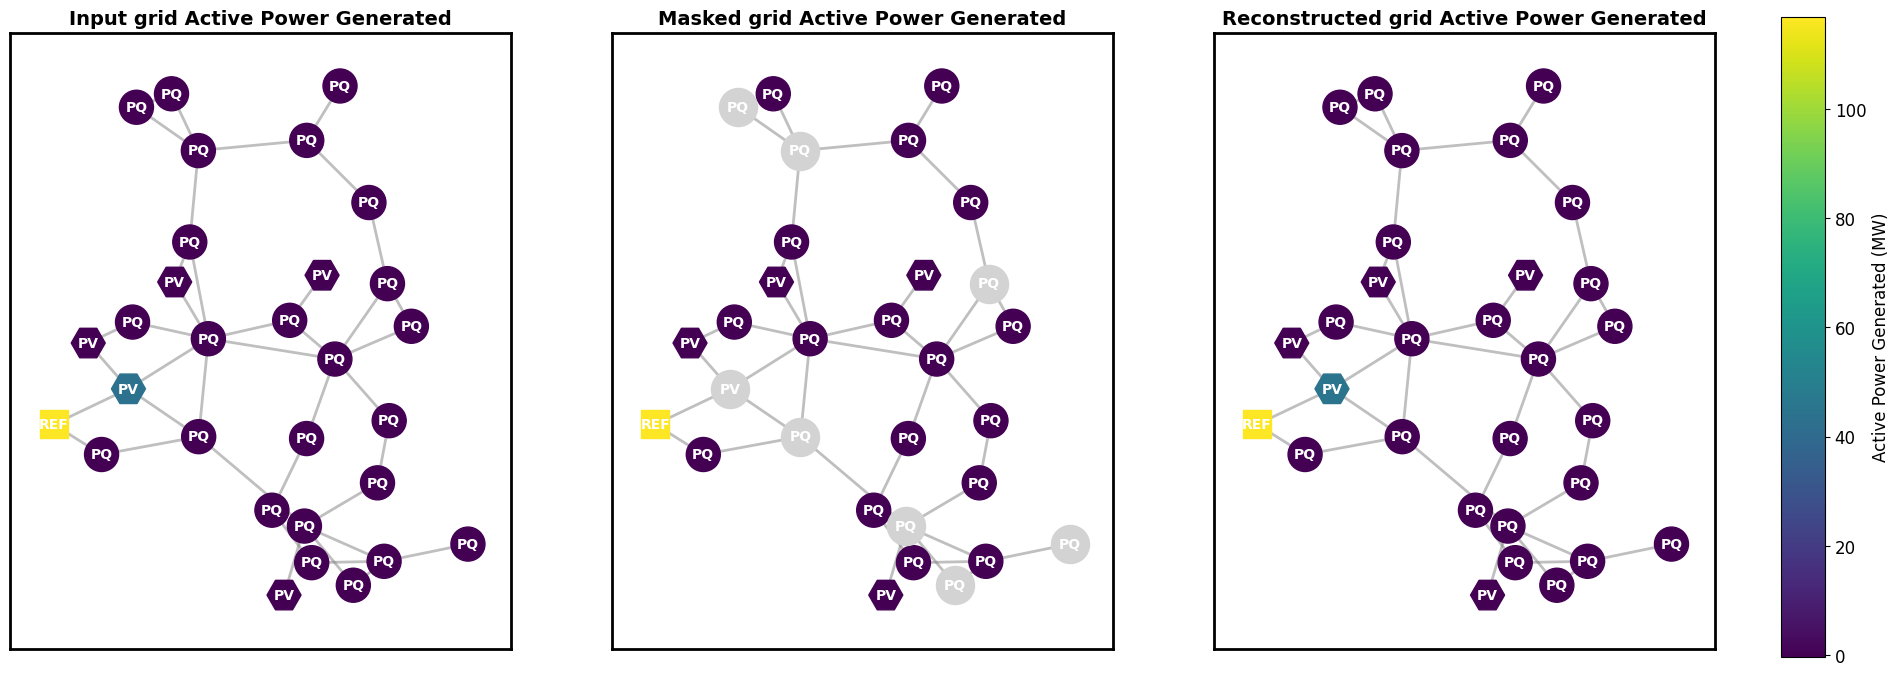

In [9]:
# Active Power Generated reconstruction
visualize_quantity_heatmap(
    data_point,
    model,
    PG,
    "Active Power Generated",
    "MW",
    node_normalizer,
    plt.cm.viridis,
    device=device,
)

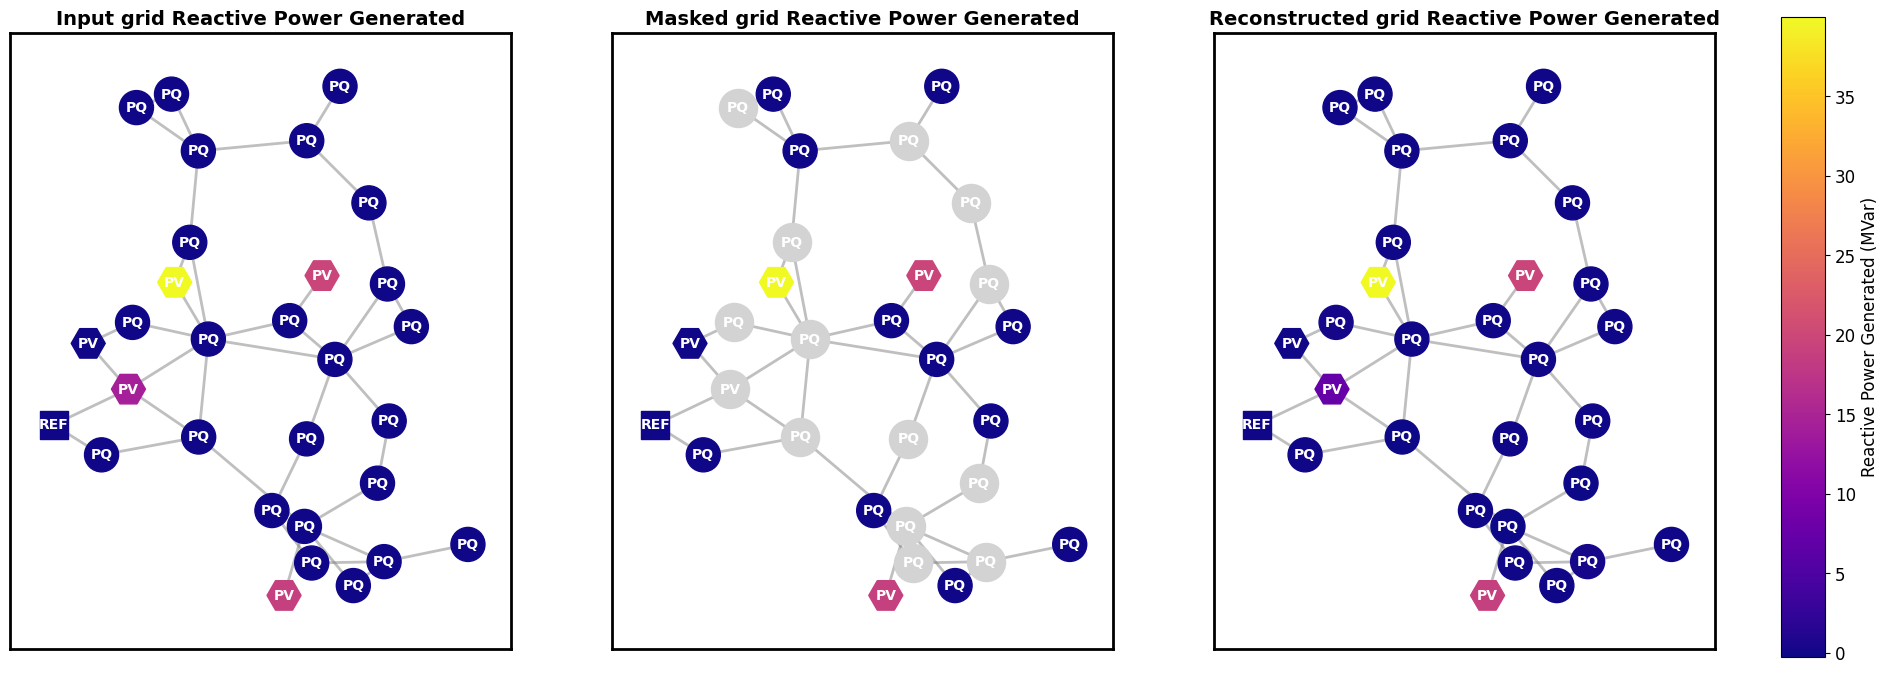

In [10]:
# Reactive Power Generated reconstruction
visualize_quantity_heatmap(
    data_point,
    model,
    QG,
    "Reactive Power Generated",
    "MVar",
    node_normalizer,
    plt.cm.plasma,
    device=device,
)

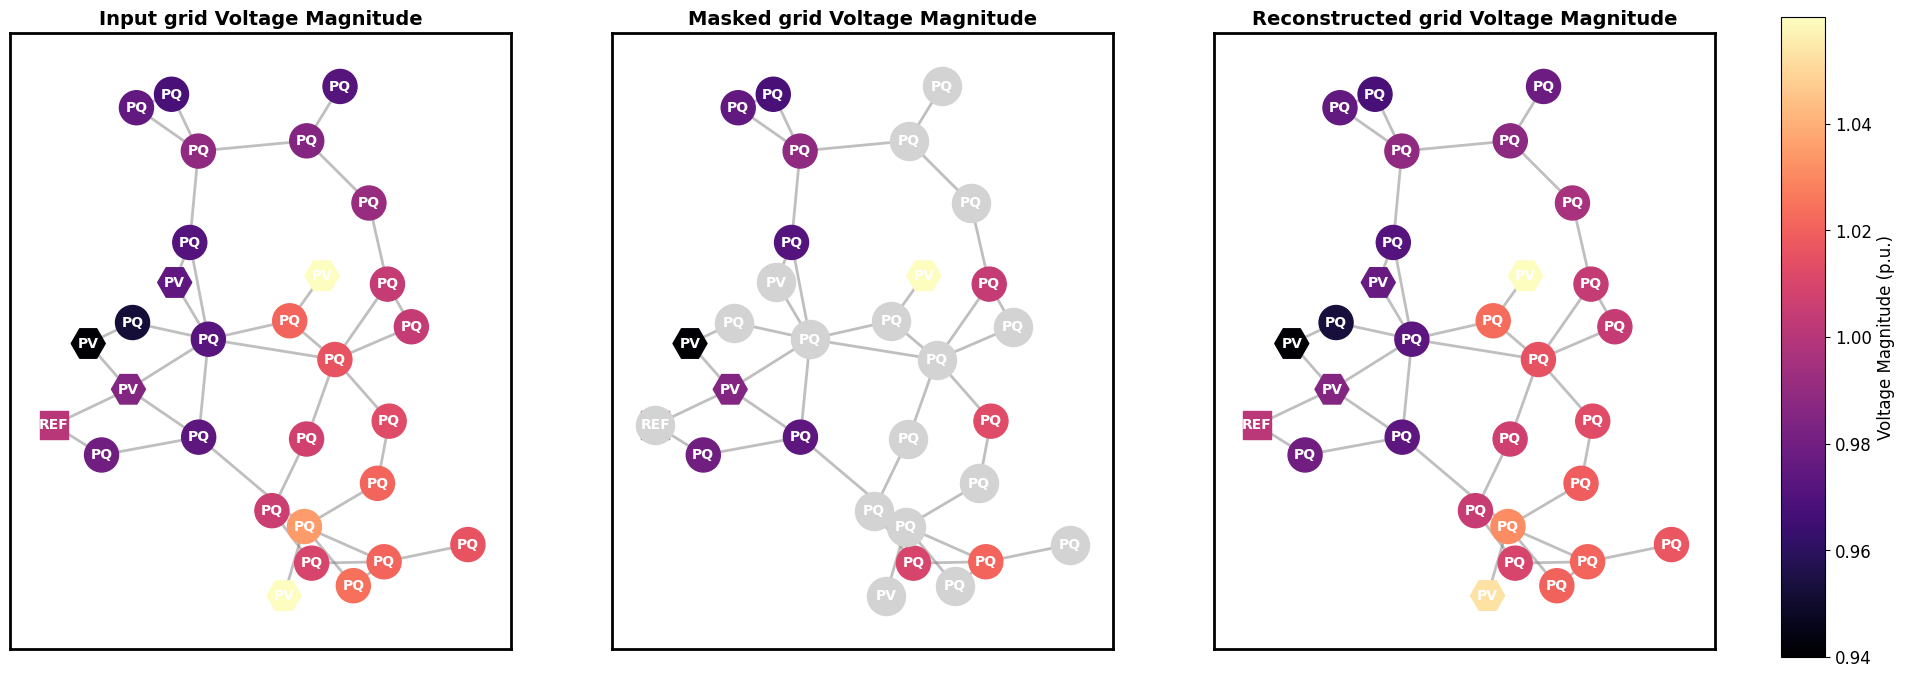

In [11]:
# Voltage magnitude reconstruction
visualize_quantity_heatmap(
    data_point,
    model,
    VM,
    "Voltage Magnitude",
    "p.u.",
    node_normalizer,
    plt.cm.magma,
    device=device,
)

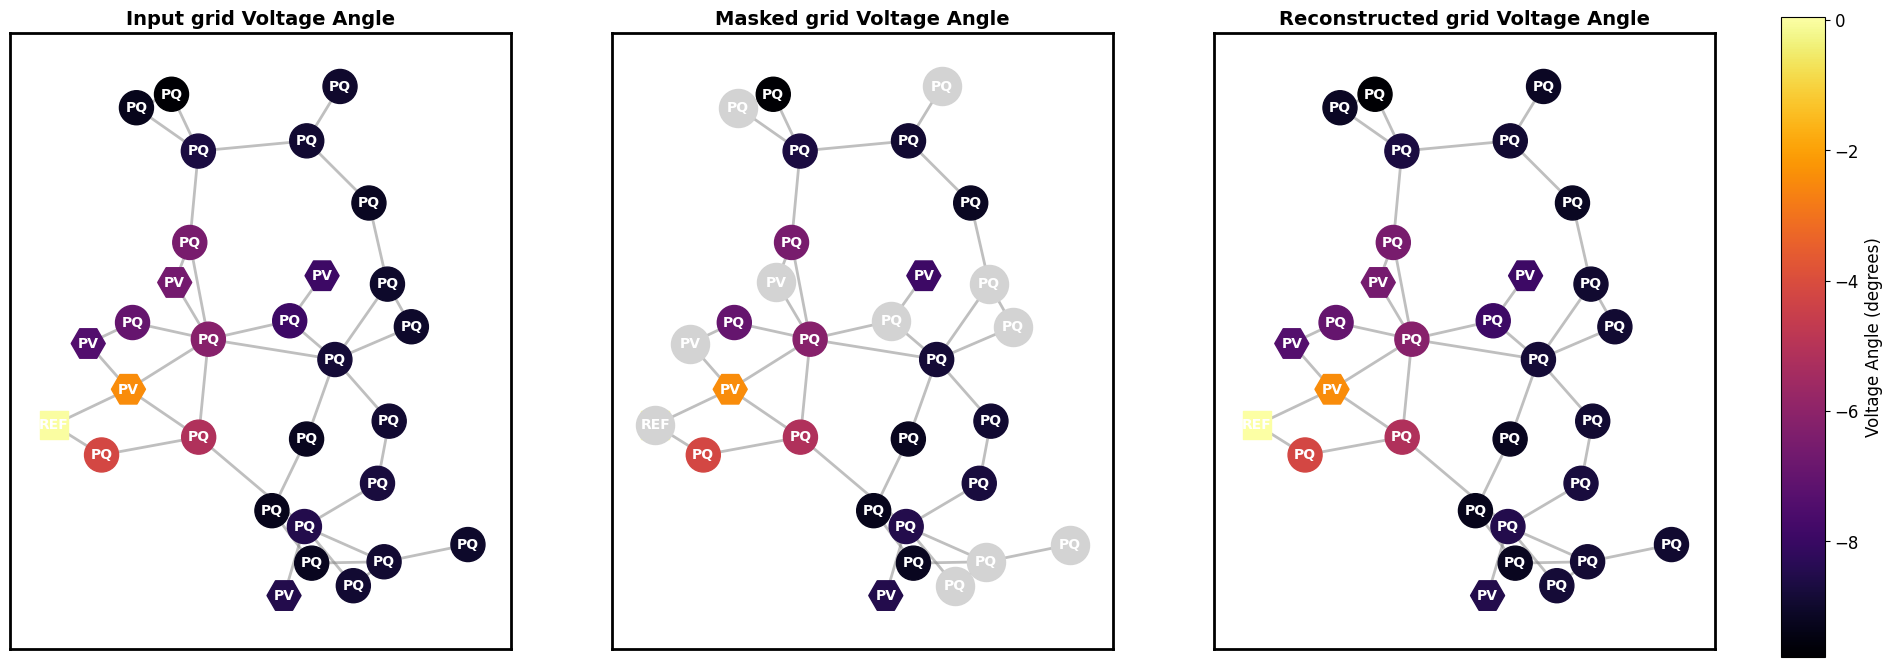

In [12]:
# Voltage angle reconstruction
visualize_quantity_heatmap(
    data_point,
    model,
    VA,
    "Voltage Angle",
    "degrees",
    node_normalizer,
    plt.cm.inferno,
    device=device,
)